# Airbnb Property Listing - Classification Modelling with Numerical Data

## Library Imports

In [159]:
import pandas as pd
import numpy as np

from zipfile import ZipFile
import data_cleaning

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Import Data

In [2]:
with ZipFile('./airbnb-property-listings.zip') as myzip:
    data = myzip.open("AirbnbDataSci/tabular_data/AirBnbData.csv")

data_df = pd.read_csv(data)
cleaned_data_df = data_df.pipe(data_cleaning.clean_tabular_data)
cleaned_data_df.head()

,id,category,title,description,amenities,location,guests,beds,bathrooms,price_night,cleanliness_rate,accuracy_rate,communication_rate,location_rate,check-in_rate,value_rate,amenities_count,url,bedrooms
0,f9dcbd09-32ac-41d9-a0b1-fdb2793378cf,Treehouses,Red Kite Tree Tent - Ynys Affalon,Escape to one of these two fabulous Tree Tents...,"['What this place offers', 'Bathroom', 'Shampo...",Llandrindod Wells United Kingdom,2.0,1.0,1.0,105.0,4.6,4.7,4.3,5.0,4.3,4.3,13.0,https://www.airbnb.co.uk/rooms/26620994?adults...,1.0
1,1b4736a7-e73e-45bc-a9b5-d3e7fcf652fd,Treehouses,Az Alom Cabin - Treehouse Tree to Nature Cabin,Come and spend a romantic stay with a couple o...,"['What this place offers', 'Bedroom and laundr...",Guyonvelle Grand Est France,3.0,3.0,0.0,92.0,4.3,4.7,4.6,4.9,4.7,4.5,8.0,https://www.airbnb.co.uk/rooms/27055498?adults...,1.0
2,d577bc30-2222-4bef-a35e-a9825642aec4,Treehouses,Cabane Entre Les Pins\n🌲🏕️🌲,"Rustic cabin between the pines, 3 meters high ...","['What this place offers', 'Scenic views', 'Ga...",Duclair Normandie France,4.0,2.0,1.5,52.0,4.2,4.6,4.8,4.8,4.8,4.7,51.0,https://www.airbnb.co.uk/rooms/51427108?adults...,1.0
3,ca9cbfd4-7798-4e8d-8c17-d5a64fba0abc,Treehouses,Tree Top Cabin with log burner & private hot tub,The Tree top cabin is situated in our peaceful...,"['What this place offers', 'Bathroom', 'Hot wa...",Barmouth Wales United Kingdom,2.0,1.0,1.0,132.0,4.8,4.9,4.9,4.9,5.0,4.6,23.0,https://www.airbnb.co.uk/rooms/49543851?adults...,1.0
5,cfe479b9-c8f8-44af-9bc6-46ede9f14bb5,Treehouses,Treehouse near Paris Disney,"Charming cabin nestled in the leaves, real unu...","['What this place offers', 'Bathroom', 'Hair d...",Le Plessis-Feu-Aussoux Île-de-France France,4.0,3.0,1.0,143.0,5.0,4.9,5.0,4.7,5.0,4.7,32.0,https://www.airbnb.co.uk/rooms/935398?adults=1...,2.0


In [3]:
cleaned_data_df.isna().sum().sum()

0

## Baseline Model - Logistic Regression
Model to predict the category column from the numerical data only

In [6]:
# Split the data into data X and label y
X = cleaned_data_df.select_dtypes('number')
y = cleaned_data_df.category
y.dtype

CategoricalDtype(categories=['Amazing pools', 'Beachfront', 'Chalets', 'Offbeat',
                  'Treehouses'],
, ordered=False)

In [10]:
# Split the data into train/test making sure to stratify the split so the test data is representative
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

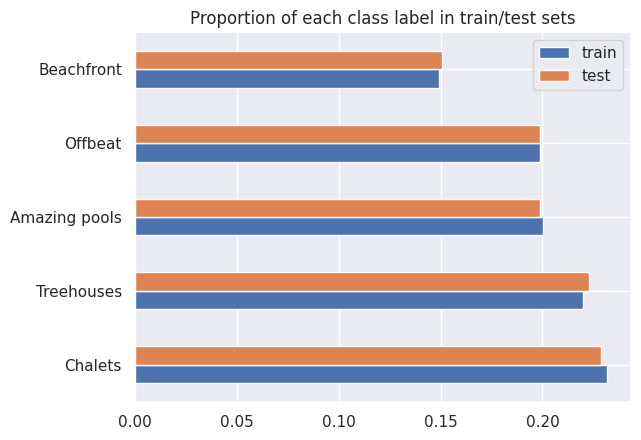

In [102]:
# Plot the proportions of each class label in the train/test data
samples_train_test_df = pd.DataFrame({'train': y_train.value_counts()/y_train.count(), 'test': y_test.value_counts()/y_test.count()})
samples_train_test_df.plot.barh(grid=True, title='Proportion of each class label in train/test sets');

In [64]:
# get a baseline score with logistic regression
train_scores = np.zeros(5,)
valid_scores = np.zeros(5,)
train_accuracy = np.zeros(5,)
valid_accuracy = np.zeros(5,)

skf = StratifiedKFold()
for fold_i, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    train_data = X_train.values[train_idx]
    valid_data = X_train.values[valid_idx]
    train_label = y_train.values[train_idx]
    valid_label = y_train.values[valid_idx]

    std_scl = StandardScaler()
    train_data_scaled = std_scl.fit_transform(train_data)
    valid_data_scaled = std_scl.transform(valid_data)

    clf_mdl = LogisticRegression(random_state=42)
    clf_mdl.fit(train_data_scaled, train_label)

    y_train_pred_prob = clf_mdl.predict_proba(train_data_scaled)
    y_valid_pred_prob = clf_mdl.predict_proba(valid_data_scaled)

    y_train_pred = clf_mdl.predict(train_data_scaled)
    y_valid_pred = clf_mdl.predict(valid_data_scaled)

    train_scores[fold_i] = log_loss(train_label, y_train_pred_prob)
    valid_scores[fold_i] = log_loss(valid_label, y_valid_pred_prob)

    train_accuracy[fold_i] = accuracy_score(train_label, y_train_pred)
    valid_accuracy[fold_i] = accuracy_score(valid_label, y_valid_pred)

print(f'Mean training loss:\t{np.mean(train_scores):.4f}')
print(f'Mean validation loss:\t{np.mean(valid_scores):.4f}\n')
print(f'Mean training accuracy:\t\t {np.mean(train_accuracy):.4f}')
print(f'Mean validation accuracy:\t {np.mean(valid_accuracy):.4f}')

Mean training loss:	1.3683
Mean validation loss:	1.4831

Mean training accuracy:		 0.4386
Mean validation accuracy:	 0.3915


In [65]:
train_data_class_ratio = y_train.value_counts().sort_index().div(y_train.count()).values

log_loss_random = log_loss(y_train.values, np.tile(train_data_class_ratio, (len(y_train),1) ))
print(f'Log Loss of the raw distribution of the training data: {log_loss_random:.4f}')

Log Loss of the raw distribution of the training data: 1.5989


Ok, so have got a model that performs better than random, but not that much better!!

Also, it is overfitting.

## Train a Random Forest Classifier

First of all, lets see if I can beat the baseline log loss without any hyper-parameter tuning

In [66]:
# Same again but with a Random Forest model
train_scores = np.zeros(5,)
valid_scores = np.zeros(5,)
train_accuracy = np.zeros(5,)
valid_accuracy = np.zeros(5,)

skf = StratifiedKFold()
for fold_i, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    train_data = X_train.values[train_idx]
    valid_data = X_train.values[valid_idx]
    train_label = y_train.values[train_idx]
    valid_label = y_train.values[valid_idx]

    rf_mdl = RandomForestClassifier(random_state=42)
    rf_mdl.fit(train_data, train_label)

    y_train_pred_prob = rf_mdl.predict_proba(train_data)
    y_valid_pred_prob = rf_mdl.predict_proba(valid_data)

    y_train_pred = rf_mdl.predict(train_data)
    y_valid_pred = rf_mdl.predict(valid_data)

    train_scores[fold_i] = log_loss(train_label, y_train_pred_prob)
    valid_scores[fold_i] = log_loss(valid_label, y_valid_pred_prob)

    train_accuracy[fold_i] = accuracy_score(train_label, y_train_pred)
    valid_accuracy[fold_i] = accuracy_score(valid_label, y_valid_pred)

print(f'Mean training loss:\t{np.mean(train_scores):.4f}')
print(f'Mean validation loss:\t{np.mean(valid_scores):.4f}\n')
print(f'Mean training accuracy:\t\t {np.mean(train_accuracy):.4f}')
print(f'Mean validation accuracy:\t {np.mean(valid_accuracy):.4f}')

Mean training loss:	0.3110
Mean validation loss:	1.5319

Mean training accuracy:		 1.0000
Mean validation accuracy:	 0.3839


Wow, that is massively overfitting.

Going to wrap this script into a function and do some initial experimentation.

In [92]:
def evaluate_model(model, params):
    train_scores = np.zeros(5,)
    valid_scores = np.zeros(5,)
    train_accuracy = np.zeros(5,)
    valid_accuracy = np.zeros(5,)

    skf = StratifiedKFold()
    for fold_i, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
        train_data = X_train.values[train_idx]
        valid_data = X_train.values[valid_idx]
        train_label = y_train.values[train_idx]
        valid_label = y_train.values[valid_idx]

        clf_mdl = model(**params)
        clf_mdl.fit(train_data, train_label)

        y_train_pred_prob = clf_mdl.predict_proba(train_data)
        y_valid_pred_prob = clf_mdl.predict_proba(valid_data)

        y_train_pred = clf_mdl.predict(train_data)
        y_valid_pred = clf_mdl.predict(valid_data)

        train_scores[fold_i] = log_loss(train_label, y_train_pred_prob)
        valid_scores[fold_i] = log_loss(valid_label, y_valid_pred_prob)

        train_accuracy[fold_i] = accuracy_score(train_label, y_train_pred)
        valid_accuracy[fold_i] = accuracy_score(valid_label, y_valid_pred)

    print(f'Mean training loss:\t{np.mean(train_scores):.4f}')
    print(f'Mean validation loss:\t{np.mean(valid_scores):.4f}\n')
    print(f'Mean training accuracy:\t\t {np.mean(train_accuracy):.4f}')
    print(f'Mean validation accuracy:\t {np.mean(valid_accuracy):.4f}')

    return {'train_loss': train_scores, 'validation_loss': valid_scores,
            'train_accuracy': train_accuracy, 'validation_accuracy': valid_accuracy}

evaluate_model(RandomForestClassifier, {'random_state': 42, 'n_estimators': 400,
                                        'max_depth': 5, 'min_samples_leaf': 3,
                                        'max_leaf_nodes': 20});

Mean training loss:	1.2201
Mean validation loss:	1.4387

Mean training accuracy:		 0.5904
Mean validation accuracy:	 0.3795


Ok, so validation loss has gone down but, accuracy has also gone down.

Still overfitting

Going to have a quick look at feature importances

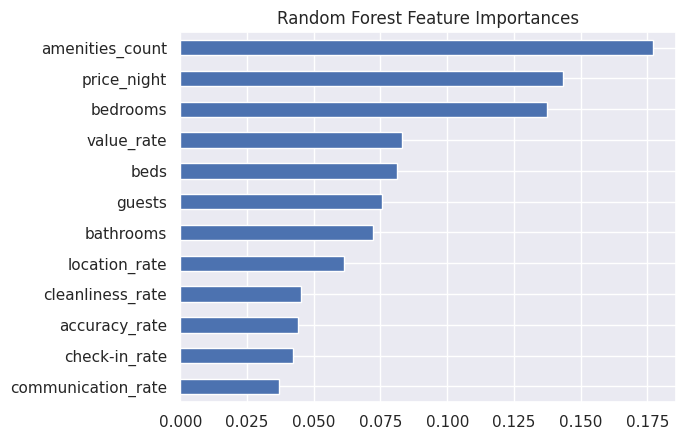

In [103]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=400, max_depth=5, 
                                min_samples_leaf=3, max_leaf_nodes=20)
rf_clf.fit(X_train, y_train)
feature_imp = pd.Series(data = rf_clf.feature_importances_, index = X_train.columns, name='feature_importances')
feature_imp.sort_values().plot.barh(title='Random Forest Feature Importances');

Lets have a look at plotting the data into two dimensions to see if it is even partitionable, going to use:
 - PCA
 - t-SNE
 - Truncated SVD

/home/danbouchard/miniconda3/envs/airbnb_predictor/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/danbouchard/miniconda3/envs/airbnb_predictor/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


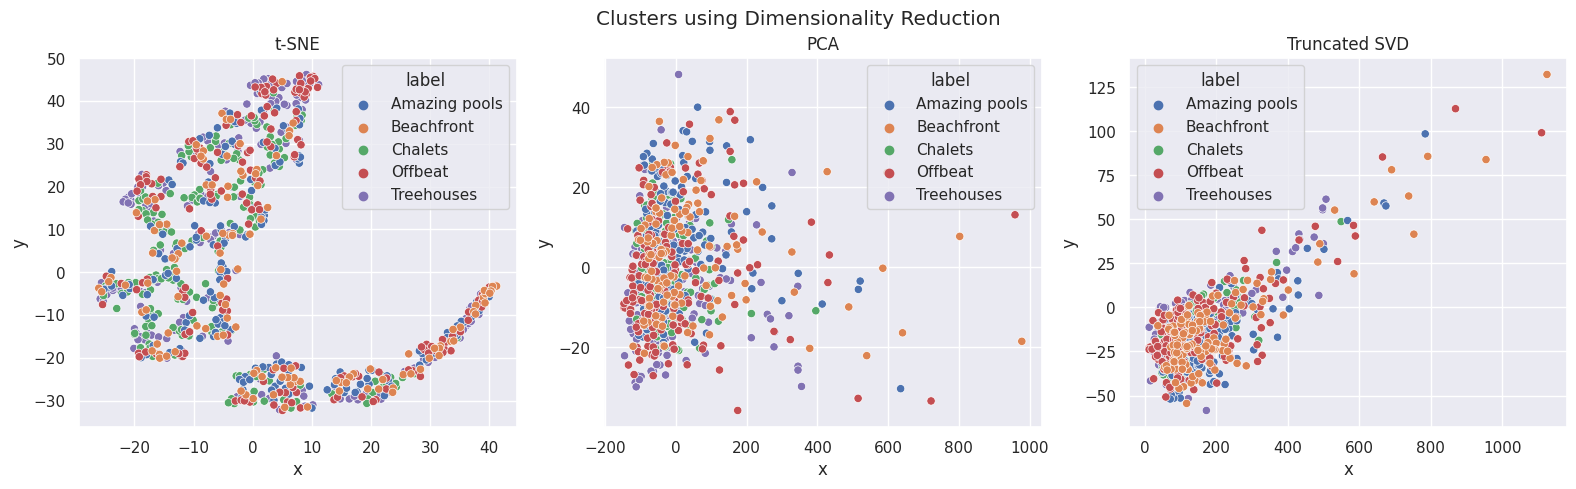

In [120]:
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
Xy_reduced_tsne = pd.DataFrame({'x': X_reduced_tsne[:,0], 'y': X_reduced_tsne[:,1], 'label': y})
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X)
Xy_reduced_pca = pd.DataFrame({'x': X_reduced_pca[:,0], 'y': X_reduced_pca[:,1], 'label': y})
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X)
Xy_reduced_svd = pd.DataFrame({'x': X_reduced_svd[:,0], 'y': X_reduced_svd[:,1], 'label': y})

fig, ax = plt.subplots(1,3, figsize=(19.2, 4.8))

sns.scatterplot(data=Xy_reduced_tsne, x='x', y='y', hue='label', ax=ax[0])
ax[0].set_title('t-SNE')
sns.scatterplot(data=Xy_reduced_pca, x='x', y='y', hue='label', ax=ax[1])
ax[1].set_title('PCA')
sns.scatterplot(data=Xy_reduced_svd, x='x', y='y', hue='label', ax=ax[2])
ax[2].set_title('Truncated SVD')
fig.suptitle('Clusters using Dimensionality Reduction');

Hmm, that is not good, clearly this data isn't great for this classification problem.

Anyway will continue for now, so if I can get some improved performance from hyper-parameter tuning.

In [150]:
def objective(trial, X, y):
    
    param_grid = {
        'n_estimators': trial.suggest_int(name='n_estimators', low=100, high=2000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'max_features': trial.suggest_categorical(
            'max_features', choices=['sqrt', 'log2']
        ),
        'min_samples_leaf': trial.suggest_int(name='min_samples_leaf', low=1, high=15),
        'max_leaf_nodes': trial.suggest_int(name='max_leaf_nodes', low=5, high=50, step=5),
        'n_jobs': -1,
        'random_state': 42,
    }

    cv = StratifiedKFold(n_splits=5)

    cv_scores = np.empty(5)
    train_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train = X.values[train_idx]
        X_test = X.values[test_idx]
        y_train = y.values[train_idx]
        y_test = y.values[test_idx]

        model = RandomForestClassifier(**param_grid)
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_test)
        train_pred = model.predict_proba(X_train)
        cv_scores[idx] = log_loss(y_test, preds)
        train_scores[idx] = log_loss(y_train, train_pred)
    
    validation_loss = np.mean(cv_scores)
    training_loss = np.mean(train_scores)
    if trial.number == 0:
        print(f'Trial {trial.number}, Validation Loss {validation_loss:.4f}, Training Loss {training_loss:.4f}, Best Trial: 0, Best Trial Value {validation_loss:.4f}')
    else:
        if validation_loss < trial.study.best_value:
            print(f'Trial {trial.number}, Validation Loss {validation_loss:.4f}, Training Loss {training_loss:.4f}, Best Trial {trial.number}, Best Trial Value {validation_loss:.4f}')
        else:    
            print(f'Trial {trial.number}, Validation Loss {validation_loss:.4f}, Training Loss {training_loss:.4f}, Best Trial {trial.study.best_trial.number}, Best Trial Value {trial.study.best_value:.4f}')

    return validation_loss

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name='Random Forest Classifier')
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=20)

Trial 0, Validation Loss 1.4685, Training Loss 1.3788, Best Trial: 0, Best Trial Value 1.4685
Trial 1, Validation Loss 1.4364, Training Loss 1.2359, Best Trial 1, Best Trial Value 1.4364
Trial 2, Validation Loss 1.4381, Training Loss 1.2426, Best Trial 1, Best Trial Value 1.4364
Trial 3, Validation Loss 1.4783, Training Loss 1.4191, Best Trial 1, Best Trial Value 1.4364
Trial 4, Validation Loss 1.4513, Training Loss 1.3371, Best Trial 1, Best Trial Value 1.4364
Trial 5, Validation Loss 1.4539, Training Loss 1.3426, Best Trial 1, Best Trial Value 1.4364
Trial 6, Validation Loss 1.4421, Training Loss 1.2652, Best Trial 1, Best Trial Value 1.4364
Trial 7, Validation Loss 1.4469, Training Loss 1.3034, Best Trial 1, Best Trial Value 1.4364
Trial 8, Validation Loss 1.4762, Training Loss 1.4159, Best Trial 1, Best Trial Value 1.4364
Trial 9, Validation Loss 1.4378, Training Loss 1.2271, Best Trial 1, Best Trial Value 1.4364
Trial 10, Validation Loss 1.4235, Training Loss 1.0456, Best Trial 10

In [151]:
study.best_value

1.4227782472305124

In [152]:
study.best_params

{'n_estimators': 1400,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'max_leaf_nodes': 40}

/tmp/ipykernel_298019/3764630561.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study);


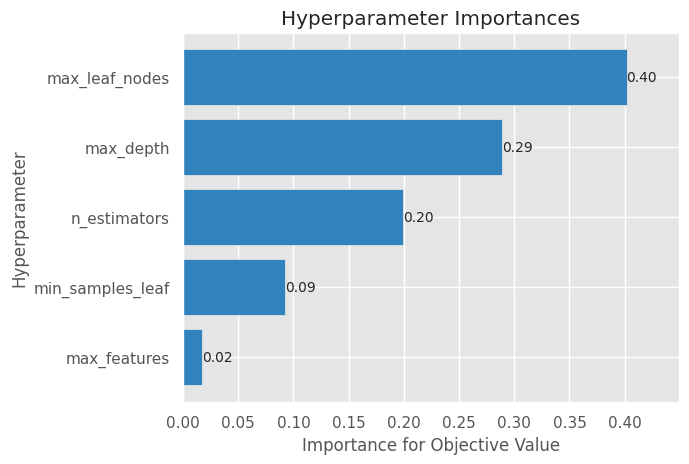

In [153]:
optuna.visualization.matplotlib.plot_param_importances(study);

/tmp/ipykernel_298019/616175072.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study);


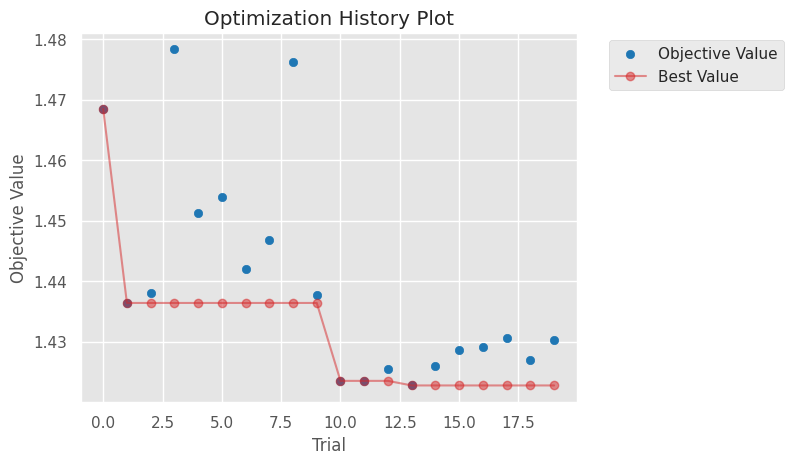

In [154]:
optuna.visualization.matplotlib.plot_optimization_history(study);

## Evaluate on test set

Log Loss:	1.3952
Accuracy:	0.3855


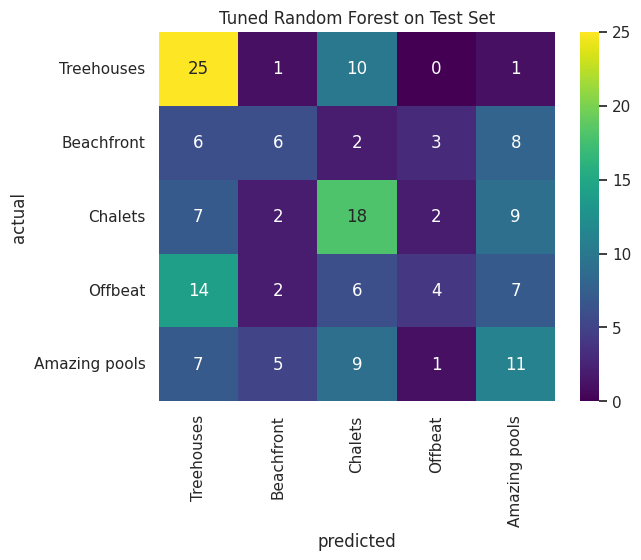

In [158]:
rf_mdl = RandomForestClassifier(random_state=42, **study.best_params)
rf_mdl.fit(X_train, y_train)
y_preds_proba = rf_mdl.predict_proba(X_test)
y_preds = rf_mdl.predict(X_test)

print(f'Log Loss:\t{log_loss(y_test, y_preds_proba):.4f}')
print(f'Accuracy:\t{accuracy_score(y_test, y_preds):.4f}')

labels = y_test.unique()
confusion_matrix_output = confusion_matrix(y_test, y_preds, labels=labels)
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix_output, annot=True, cmap='viridis', 
            xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')
ax.set_title('Tuned Random Forest on Test Set');

## Try Feature Engineering the description column

In [165]:
# Create a new train and test set with a new feature X, making sure to stratify y
X_text_train, X_text_test, y_train, y_test = train_test_split(cleaned_data_df.description, cleaned_data_df.category, test_size=0.2, random_state=42, stratify=cleaned_data_df.category)

In [166]:
# get a baseline score with logistic regression
train_scores = np.zeros(5)
valid_scores = np.zeros(5)
train_accuracy = np.zeros(5)
valid_accuracy = np.zeros(5)

skf = StratifiedKFold()
for fold_i, (train_idx, valid_idx) in enumerate(skf.split(X_text_train, y_train)):
    train_data = X_text_train.values[train_idx]
    valid_data = X_text_train.values[valid_idx]
    train_label = y_train.values[train_idx]
    valid_label = y_train.values[valid_idx]

    vectoriser = TfidfVectorizer(strip_accents='ascii', stop_words='english')
    train_data_tfidf = vectoriser.fit_transform(train_data)
    valid_data_tfidf = vectoriser.transform(valid_data)

    clf_mdl = LogisticRegression(random_state=42)
    clf_mdl.fit(train_data_tfidf, train_label)

    y_train_pred_prob = clf_mdl.predict_proba(train_data_tfidf)
    y_valid_pred_prob = clf_mdl.predict_proba(valid_data_tfidf)

    y_train_pred = clf_mdl.predict(train_data_tfidf)
    y_valid_pred = clf_mdl.predict(valid_data_tfidf)

    train_scores[fold_i] = log_loss(train_label, y_train_pred_prob)
    valid_scores[fold_i] = log_loss(valid_label, y_valid_pred_prob)

    train_accuracy[fold_i] = accuracy_score(train_label, y_train_pred)
    valid_accuracy[fold_i] = accuracy_score(valid_label, y_valid_pred)

print(f'Mean training loss:\t{np.mean(train_scores):.4f}')
print(f'Mean validation loss:\t{np.mean(valid_scores):.4f}\n')
print(f'Mean training accuracy:\t\t {np.mean(train_accuracy):.4f}')
print(f'Mean validation accuracy:\t {np.mean(valid_accuracy):.4f}')

Mean training loss:	0.6058
Mean validation loss:	0.8564

Mean training accuracy:		 0.9910
Mean validation accuracy:	 0.8509


Ok, this is so much better, this is definitely the way to go.

But it is still overfitting.

In [216]:
# Lets have a look at the best tokenisers
vectoriser = TfidfVectorizer(strip_accents='ascii', stop_words='english')
train_data_tfidf = vectoriser.fit_transform(X_text_train.values)
log_reg = LogisticRegression(random_state=42)
log_reg.fit(train_data_tfidf, y_train.values)
index_to_term = {index: term for term, index in vectoriser.vocabulary_.items()}

top_words_dict = dict()
for i in range(5):
    top_coefs_idx = np.argpartition(log_reg.coef_[i,:], -15)[-15:]
    top_words = [index_to_term[idx] for idx in top_coefs_idx]
    top_coefs_value = log_reg.coef_[i,top_coefs_idx]
    top_words_dict[log_reg.classes_[i]] = dict(words=top_words, coef_values=top_coefs_value)

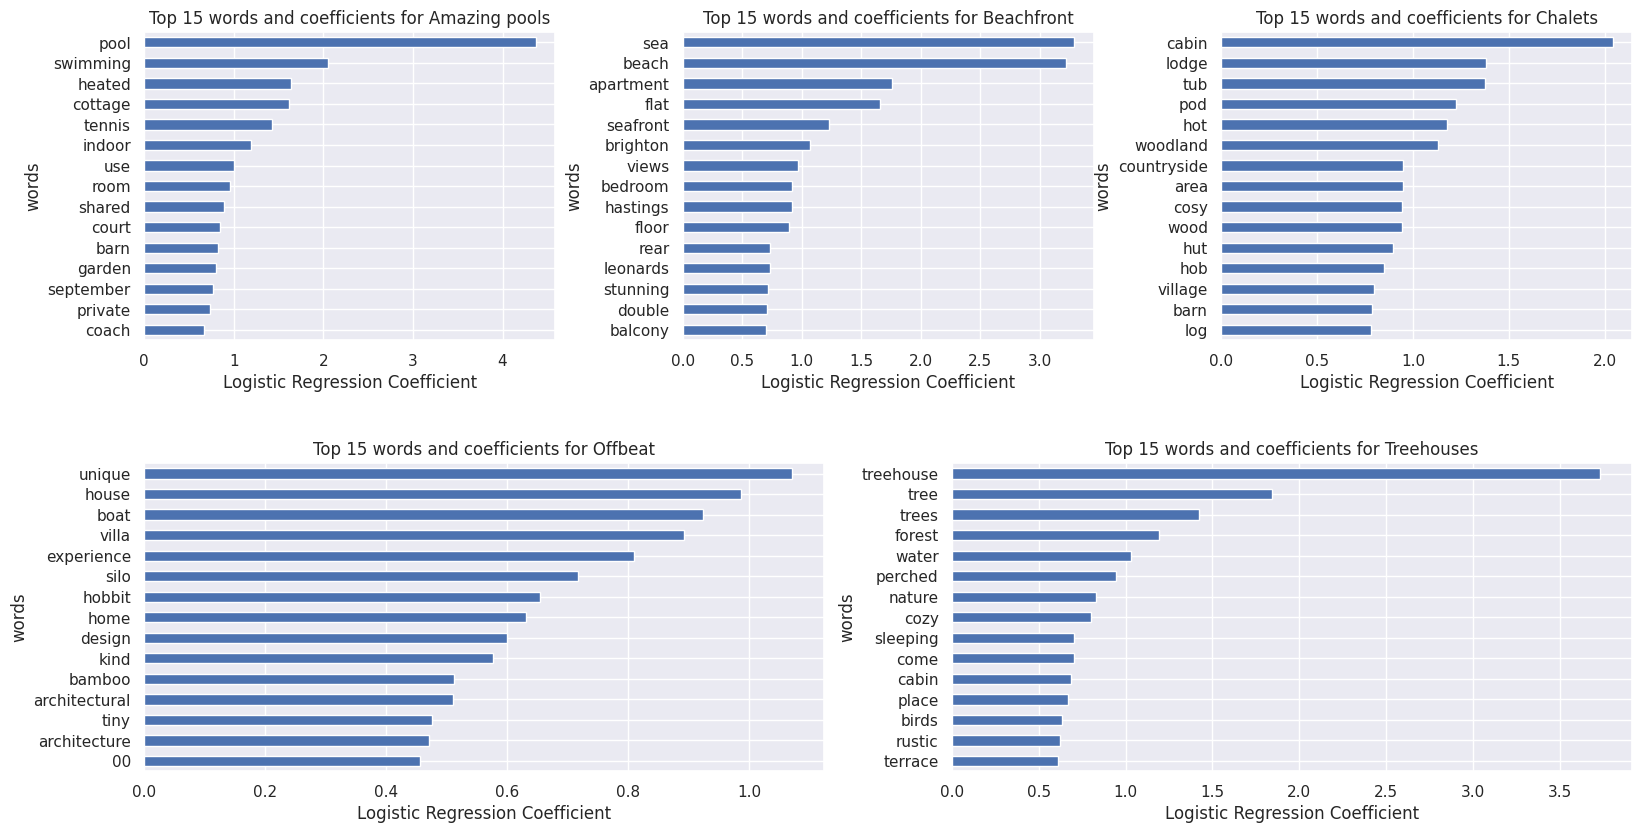

In [217]:
fig = plt.figure(figsize=(19.2, 9.6))
grid = plt.GridSpec(2, 6, wspace = .9, hspace = .4)
ax0 = plt.subplot(grid[0,:2])
ax1 = plt.subplot(grid[0,2:4])
ax2 = plt.subplot(grid[0,4:])
ax3 = plt.subplot(grid[1,:3])
ax4 = plt.subplot(grid[1,3:])
axs = [ax0, ax1, ax2, ax3, ax4]

for i, label in enumerate(top_words_dict.keys()):
    pd.DataFrame(top_words_dict[label]).set_index('words').squeeze().sort_values().plot.barh(ax=axs[i], title=f'Top 15 words and coefficients for {label}')
    axs[i].set_xlabel('Logistic Regression Coefficient')